In [72]:
from numpy import cumsum
from datetime import datetime
from typing import List, Tuple

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from Experiments.FundHistorySummary import FundHistorySummary

def show_summary_grid(fund_history_summary: FundHistorySummary) -> None:
    sns.set(rc={'figure.figsize':(26,15)})
    f, axes = plt.subplots(2, 2)

    start_wealth = 500
    bet_limit_fraction = 0.5
    show_fixed_betting_wealth_progression(axes[0][0], fund_history_summary, start_wealth=start_wealth, betting_limit=100)
    show_dynamic_betting_wealth_progression(axes[0][1], fund_history_summary, start_wealth=start_wealth, bet_limit_fraction=bet_limit_fraction)

    win_bet_limit_ratio = fund_history_summary.validation_score
    current_wealth_snapshots, absolute_wealth_gain_snapshot = simulate_wealth_growth(
        start_wealth=start_wealth,
        win_bet_limit_ratio=win_bet_limit_ratio,
        bet_limit_fraction=bet_limit_fraction,
    )

    show_long_term_wealth_progression(axes[1][0], start_wealth, current_wealth_snapshots, win_bet_limit_ratio, bet_limit_fraction)
    show_long_term_income_progression(axes[1][1], start_wealth, absolute_wealth_gain_snapshot, win_bet_limit_ratio, bet_limit_fraction)

def show_fixed_betting_wealth_progression(axis, fund_history_summary: FundHistorySummary, start_wealth: float, betting_limit: float):
    dates = [snapshot.date.split()[0] for snapshot in fund_history_summary.snapshots]
    absolute_payouts = [snapshot.payout_percentages * betting_limit for snapshot in fund_history_summary.snapshots]
    wealth_progression = [start_wealth + payout_sum for payout_sum in cumsum(absolute_payouts)]

    sns.lineplot(x=dates, y=wealth_progression, ax=axis)

    max_date = datetime.strptime(max(dates), '%Y-%m-%d')
    min_date = datetime.strptime(min(dates), '%Y-%m-%d')
    summary_day_interval = (max_date - min_date).days
    axis.xaxis.set_major_locator(mdates.DayLocator(interval=int(summary_day_interval / 5)))

    axis.set_title(f"Wealth progression over unseen test races. Betting limit is: {betting_limit}")
    axis.set_xlabel(f"Date")
    axis.set_ylabel(f"Current Wealth")

def show_dynamic_betting_wealth_progression(axis, fund_history_summary: FundHistorySummary, start_wealth: float, bet_limit_fraction: float) -> None:
    dates = [snapshot.date.split()[0] for snapshot in fund_history_summary.snapshots]

    current_wealth = start_wealth
    wealth_progression = []
    for i in range(len(fund_history_summary.snapshots)):
        betting_limit = current_wealth * bet_limit_fraction
        current_wealth += fund_history_summary.snapshots[i].payout_percentages * betting_limit
        wealth_progression.append(current_wealth)

    sns.lineplot(x=dates, y=wealth_progression, ax=axis)

    max_date = datetime.strptime(max(dates), '%Y-%m-%d')
    min_date = datetime.strptime(min(dates), '%Y-%m-%d')
    summary_day_interval = (max_date - min_date).days
    axis.xaxis.set_major_locator(mdates.DayLocator(interval=int(summary_day_interval / 5)))

    axis.set_title(f"Wealth progression over unseen test races. Betting limit is current wealth multiplied by {bet_limit_fraction:.2f}")
    axis.set_xlabel(f"Date")
    axis.set_ylabel(f"Current Wealth")

def show_long_term_wealth_progression(axis, start_wealth: float, current_wealth_snapshots: List[float], win_bet_limit_ratio: float, bet_limit_fraction: float) -> None:
    axis.set_title(f"Wealth progression of (payout per month/bet limit)={win_bet_limit_ratio: .2f} with start wealth {start_wealth} and betting limit: {bet_limit_fraction} * current wealth", fontsize=10)
    axis.set_xlabel("Month")
    axis.set_ylabel("Wealth")

    sns.lineplot(current_wealth_snapshots, ax=axis)

def show_long_term_income_progression(axis, start_wealth: float, absolute_wealth_gain_snapshot: List[float], win_bet_limit_ratio: float, bet_limit_fraction: float) -> None:
    axis.set_title(f"Income progression of (payout per month/bet limit)={win_bet_limit_ratio: .2f} with start wealth {start_wealth} and betting limit: {bet_limit_fraction} * current wealth", fontsize=10)
    axis.set_xlabel("Month")
    axis.set_ylabel("Income")

    sns.lineplot(absolute_wealth_gain_snapshot, ax=axis)
    
def show_success_rate(fund_history_summaries):
    successfull_summaries = [fund_history_summary for fund_history_summary in fund_history_summaries 
                             if fund_history_summary.win_loss_ratio > 1.0]
    n_successfull_summaries = len(successfull_summaries)
    success_percentage = (n_successfull_summaries / len(fund_history_summaries)) * 100
    print(f"Success rate: {success_percentage}%")

def simulate_wealth_growth(win_bet_limit_ratio: float, start_wealth: float = 2000, bet_limit_fraction: float = 0.2, month_window_size: int = 36) -> Tuple[List[float], List[float]]:
    current_wealth_snapshots = [start_wealth]
    absolute_wealth_gain_snapshot = []
    for i in range(month_window_size):
        bet_limit = current_wealth_snapshots[-1] * bet_limit_fraction
        absolute_wealth_gain = bet_limit * win_bet_limit_ratio
        current_wealth_snapshots.append(current_wealth_snapshots[-1] + absolute_wealth_gain)
        absolute_wealth_gain_snapshot.append(absolute_wealth_gain)

    return current_wealth_snapshots, absolute_wealth_gain_snapshot

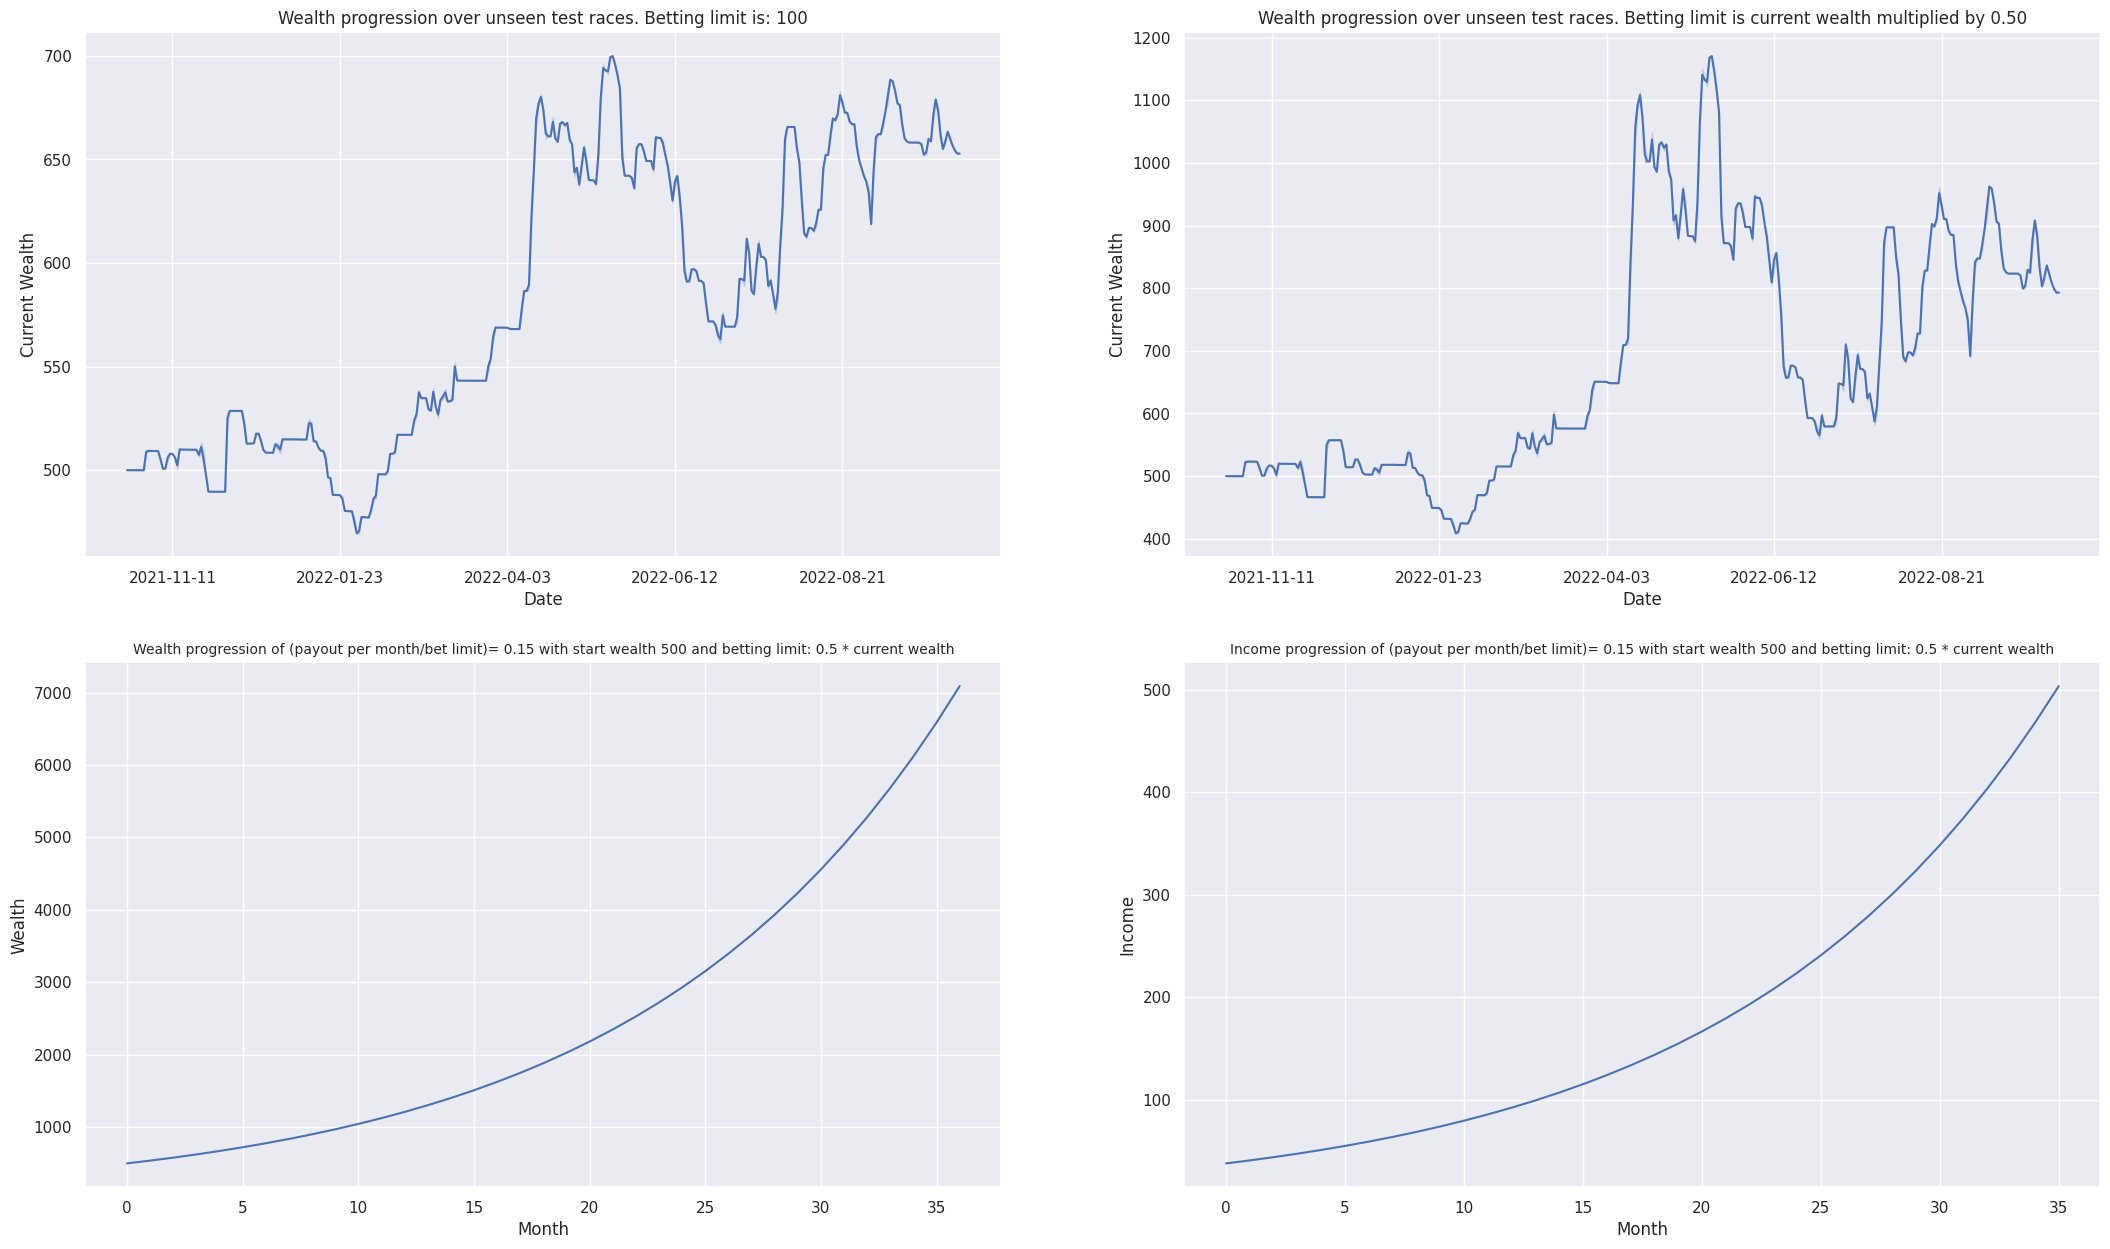

In [73]:
import pickle

FUND_HISTORY_SUMMARIES_PATH = "../data/fund_history_summaries.dat"

with open(FUND_HISTORY_SUMMARIES_PATH, "rb") as f:
    fund_history_summary = pickle.load(f)

show_summary_grid(fund_history_summary)

0.03
min:0.0004018603175260511
max:0.39049800432187476
avg:0.06452464441753719


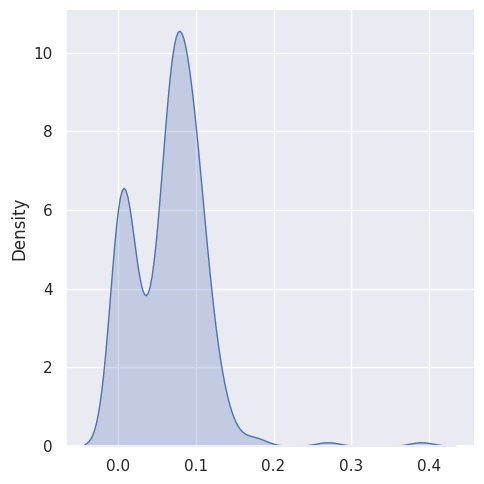

In [71]:
from numpy import average

losses = [betting_slip.loss for betting_slip in fund_history_summary.betting_slips.values() if betting_slip.loss > 0]
non_betting_slips = [betting_slip for betting_slip in fund_history_summary.betting_slips.values() if len(betting_slip.bets) == 0]
real_betting_slips = [betting_slip for betting_slip in fund_history_summary.betting_slips.values() if len(betting_slip.bets) > 0]
print(len(real_betting_slips) / (len(real_betting_slips) + len(non_betting_slips)))

print(f"min:{min(losses)}")
print(f"max:{max(losses)}")
print(f"avg:{average(losses)}")
ax = sns.displot(x=losses, kind="kde", fill=True)

Average positive wealth start: 382.8107
1354.0999999999985


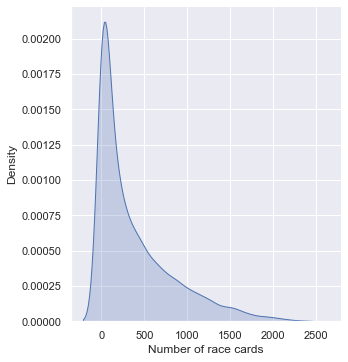

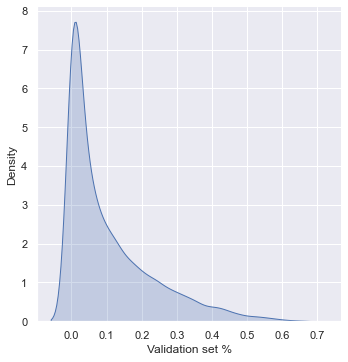

In [5]:
from statistics import mean
import random

def get_positive_wealth_start_idx(payouts: List[float], start_wealth: float):
    wealth_snapshots = [0]
    wealth = start_wealth

    payouts = random.sample(payouts, k=len(payouts))
    for payout in payouts:
        wealth += payout
        wealth_snapshots.append(wealth)

    for bet_slip_idx, wealth_snapshot in enumerate(reversed(wealth_snapshots)):
        if wealth_snapshot < start_wealth:
            return len(wealth_snapshots) - bet_slip_idx - 1

    return 0

payouts = fund_history_summary[0].payouts
start_wealth = fund_history_summary[0].start_wealth
positive_wealth_starts = [get_positive_wealth_start_idx(payouts, start_wealth) for _ in range(10000)]
relative_positive_wealth_starts = [positive_wealth_start / len(payouts) for positive_wealth_start in positive_wealth_starts]

print(f"Average positive wealth start: {mean(positive_wealth_starts)}")
print(np.percentile(positive_wealth_starts, q=95))
ax = sns.displot(x=positive_wealth_starts, kind="kde", fill=True)
ax.set_axis_labels(x_var="Number of race cards")

ax = sns.displot(x=relative_positive_wealth_starts, kind="kde", fill=True)
ax.set_axis_labels(x_var="Validation set %")